<a id="top"></a>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using tensorflow and keras</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [Github: tensorflow](https://github.com/tensorflow/tensorflow)
- [Kaggle: Churn Deep-Learning VS XGBoost](https://www.kaggle.com/snanilim/churn-deep-learning-vs-xgboost)
- [Kaggle: Churn Prediction Neural Network and ML models](https://www.kaggle.com/devarshraval/churn-prediction-neural-network-and-ml-models)

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [1]:
import time

time_start_notebook = time.time()

## Colab

In [2]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO
    !git clone https://github.com/thuijskens/scikit-hyperband.git
    sys.path.append('scikit-hyperband/hyperband')
    from search import HyperbandSearchCV

    # deep learning
    !pip install lrcurve


    print('Environment: Google Colab')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()

from tqdm import tqdm_notebook as tqdm

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly


import tensorflow as tf
import lrcurve
from lrcurve import KerasLearningCurve


%load_ext watermark
%watermark -iv

seaborn    0.10.1
pandas     1.1.1
tensorflow 2.3.1
numpy      1.18.5



<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [4]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

In [5]:
def set_random_seed(seed):
    import os
    import random
    import numpy as np
    import tensorflow as tf
    
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [6]:
path_data_train = '../data/raw/train.csv'
path_data_test = '../data/raw/test.csv'

if ENV_COLAB:
    path_data_train = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/train.csv'
    path_data_test = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/test.csv'

In [7]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 21)
(1409, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1621-YNCJH,Female,0,Yes,No,36,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,Yes,Two year,Yes,Credit card (automatic),106.05,3834.4,No
1,7143-BQIBA,Male,0,No,No,10,Yes,No,DSL,Yes,No,No,Yes,Yes,No,Month-to-month,No,Bank transfer (automatic),62.25,612.95,No
5632,0862-PRCBS,Female,0,Yes,Yes,68,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),103.75,7039.45,No
5633,4656-CAURT,Male,0,No,No,69,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.95,1713.1,No


In [8]:
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [9]:
def clean_data(dfx):
    dfx = dfx.copy()

    # from eda we see that gender has no effect
    cols_drop = ['customerID','gender']
    dfx = dfx.drop(cols_drop,axis=1)

    # impute 
    dfx['TotalCharges'] = pd.to_numeric(dfx['TotalCharges'],errors='coerce').fillna(0)

    # one hot encoding
    cols_cat = dfx.select_dtypes('object').columns
    dfx = pd.get_dummies(dfx,columns=cols_cat,drop_first=False)
    return dfx

In [10]:
df_Xtrain_full = clean_data(df_train.drop(target_name,axis=1))
df_Xtest  = clean_data(df_test.drop(target_name,axis=1))

ser_ytrain_full = df_train[target_name].map({'No':0,'Yes':1})
ser_ytest = df_test[target_name].map({'No':0,'Yes':1})

ytrain_full = np.array(ser_ytrain_full).ravel()
ytest = np.array(ser_ytest).ravel()

In [11]:
print(df_Xtrain_full.sum().sum(), df_Xtest.sum().sum(),
      df_Xtrain_full.isna().sum().sum(), df_Xtest.isna().sum().sum())

df_Xtrain_full.head()

13426940.15 3413079.1500000004 0 0


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,36,106.05,3834.40,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,10,62.25,612.95,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0
2,0,25,19.15,477.60,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,0,7,20.00,137.60,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0
4,1,24,20.30,459.95,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1


<a id="" ></a>

<h1>  Train Validation Split</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [12]:
from sklearn.model_selection import train_test_split

df_Xtrain, df_Xvalid, ser_ytrain, ser_yvalid = train_test_split(
    df_Xtrain_full, ser_ytrain_full,
    test_size=0.2, random_state=SEED, stratify=ser_ytrain_full)

ytrain = ser_ytrain.to_numpy().ravel()
yvalid = ser_yvalid.to_numpy().ravel()

<a id="" ></a>

<h1>  Scaling </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(df_Xtrain_full)

Xtrain_full = scaler.transform(df_Xtrain_full)
Xtest       = scaler.transform(df_Xtest)

<a id="" ></a>

<h1>  Class Weights for Imbalanced Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [14]:
# for imbalanced data we can use class_weight
neg,pos = np.bincount(ytrain_full)
weight_for_0 = 1.0 / neg
weight_for_1 = 1.0 / pos

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.00024160425223483932, 1: 0.0006688963210702341}


In [15]:
# for imbalanced data, bias_initializer help fast converging
bias_init_last_layer = np.log([pos/neg])
print(bias_init_last_layer)

[-1.01832801]


<a id="" ></a>

<h1>  Modelling: Keras  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [16]:
import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import StratifiedKFold

import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [17]:
# show_methods(keras.metrics)

In [18]:
def build_fn(units, activation,n_feats):
    model = Sequential()
    for i, u in enumerate(units):
        if i == 0:
            model.add(Dense(u, kernel_initializer = 'he_uniform',
                            activation=activation,input_dim = n_feats))
            model.add(Dropout(0.1))
        else:
            model.add(Dense(u, kernel_initializer = 'he_uniform',
                            activation=activation))
            model.add(Dropout(0.1))

    # output layer
    model.add(Dense(1, kernel_initializer = 'glorot_uniform',
                    activation = 'sigmoid'))
 
    # compile
    model.compile(optimizer='Adamax',
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC(name='roc_auc')]
                  )
    return model

In [19]:
%%time

import warnings
warnings.simplefilter('ignore')

model = KerasClassifier(build_fn=build_fn, verbose=0)
n_feats     = df_Xtrain_full.shape[1]


units       = [(6, 3, 3), (10, 10), (45, 30, 15)]
batch_size  = [128, 256]
activations = ['sigmoid', 'relu']
epochs      = [30]

params_grid = dict(
    units      = units,
    activation = activations,
    batch_size = batch_size,
    epochs     = epochs,
    n_feats    = [n_feats]
    )


grid = GridSearchCV(model,params_grid,cv=5,n_jobs=1,scoring='roc_auc') 
# use n_jobs=1 to prevent memory leak

# grid = grid.fit(df_Xtrain_full, ytrain_full)
# best_params = grid.best_params_

best_params = """

{'activation': 'sigmoid',
 'batch_size': 128,
 'epochs': 30,
 'n_feats': 43,
 'units': (45, 30, 15)}
"""

CPU times: user 183 µs, sys: 0 ns, total: 183 µs
Wall time: 187 µs


In [20]:
model = build_fn(units=(45, 30, 15), activation='sigmoid',n_feats=n_feats)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 45)                1980      
_________________________________________________________________
dropout (Dropout)            (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1380      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [21]:
history = model.fit(
    df_Xtrain_full,ytrain_full,
    batch_size=128,
    epochs=30,
    verbose=0,
    callbacks=[],
    class_weight=class_weight
)

<a id="" ></a>

<h1>  Model Evaluation </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [22]:
yprobs   = model.predict(df_Xtest).flatten()
yprobs2d = np.c_[1-yprobs,yprobs]
ypreds   = (yprobs.flatten()>0.5).astype(np.int8)

              precision    recall  f1-score   support

           0       0.87      0.67      0.76      1035
           1       0.44      0.72      0.55       374

    accuracy                           0.68      1409
   macro avg       0.66      0.70      0.65      1409
weighted avg       0.75      0.68      0.70      1409

[[697 338]
 [106 268]]


,Accuracy,Precision,Recall,F1-score,AUC
keras,0.6849,0.4422,0.7166,0.5469,0.6950


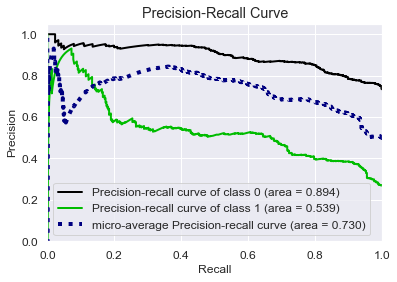

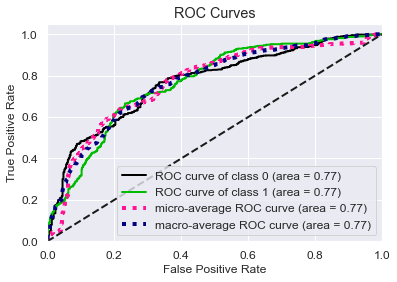

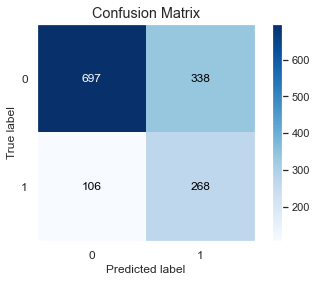

In [23]:
def model_eval_bin(model_name,ytest,ypreds,yprobs2d,show_plots=True):
    import sklearn.metrics as skmetrics
    import scikitplot.metrics as skpmetrics
    import os

    acc       = skmetrics.accuracy_score(ytest,ypreds)
    precision = skmetrics.precision_score(ytest,ypreds)
    recall    = skmetrics.recall_score(ytest,ypreds)
    f1        = skmetrics.f1_score(ytest,ypreds)
    auc       = skmetrics.roc_auc_score(ytest,ypreds)

    print(skmetrics.classification_report(ytest,ypreds))
    print(skmetrics.confusion_matrix(ytest,ypreds))

    df_res = pd.DataFrame({'Accuracy':[acc],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1-score': [f1],
                          'AUC': [auc]},index=[model_name])

    display(df_res.style.format("{:.4f}"))
    if not os.path.isdir('../outputs'):
        os.makedirs('../outputs')
    o = '.' if ENV_COLAB else '../outputs/'
    df_res.to_csv(o+f'model_{model_name}.csv',index=True)

    if show_plots:
        skpmetrics.plot_precision_recall(ytest,yprobs2d) # more focus on minority
        skpmetrics.plot_roc_curve(ytest,yprobs2d) # equal focus on both groups
        skpmetrics.plot_confusion_matrix(ytest,ypreds)

model_eval_bin('keras',ytest,ypreds,yprobs2d,show_plots=True)

# Development

In [24]:
def plot_keras_history(history,metric):
    plt.plot(history.history[metric]) 
    plt.plot(history.history['val_'+metric]) 
    plt.title(metric) 
    plt.ylabel(metric)
    plt.xlabel('epoch') 
    plt.legend(['train', 'test'], loc='upper left') 
    plt.show()

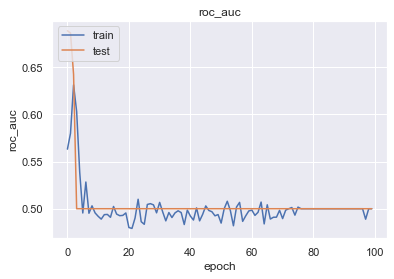

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409

[[1035    0]
 [ 374    0]]


,Accuracy,Precision,Recall,F1-score,AUC
keras_2,0.7346,0.0000,0.0000,0.0000,0.5000


CPU times: user 21.2 s, sys: 2.49 s, total: 23.7 s
Wall time: 16 s


In [27]:
%%time

import tensorflow as tf
import lrcurve
from lrcurve import KerasLearningCurve


n_feats = df_Xtrain.shape[1]
METRIC = 'roc_auc' # use this name so that we can do sklearn gridsearch
n_rows = df_Xtrain.shape[0]


set_random_seed(SEED)

def get_model(n_rows,n_feats):
    model = Sequential()

    # first layer
    model.add(Dense(128,
                    kernel_regularizer=tf.keras.regularizers.l2(0.1),
                    input_dim=n_feats,
                    activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))

    # middle layers
    model.add(Dense(64,
                    kernel_regularizer=tf.keras.regularizers.l2(0.1),
                    activation='relu' ))
    model.add(Dropout(rate=0.4))

    model.add(Dense(16,
                    kernel_regularizer=tf.keras.regularizers.l2(0.1),
                    activation='relu'))
    model.add(Dropout(rate=0.3))

    # last layer
    model.add(Dense(1, activation='sigmoid'))
 
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001,
        decay_steps=(n_rows/32)*50,
        decay_rate=1,
        staircase=False)

    optimizer = tf.keras.optimizers.Adam(lr_schedule)
    model.compile(
        loss = "binary_crossentropy", 
        optimizer = optimizer, 
        metrics=[tf.keras.metrics.AUC(name=METRIC)]
        )
    
    return model


cb_early  = tf.keras.callbacks.EarlyStopping(monitor='val_'+METRIC,
                                             patience=50,
                                             restore_best_weights=True)
cb_lr = lrcurve.KerasLearningCurve()
callbacks = [
            #  cb_early,
             cb_lr]


model = get_model(n_rows=n_rows,n_feats=n_feats)

history = model.fit(df_Xtrain, ytrain,
                    validation_data=(df_Xvalid, yvalid),
                    epochs=100,
                    batch_size=64,
                    callbacks=callbacks,
                    class_weight=class_weight,
                    verbose=0
                    )

yprobs   = model.predict(df_Xtest).flatten()
yprobs2d = np.c_[1-yprobs,yprobs]
ypreds   = (yprobs.flatten()>0.5).astype(np.int8)

plot_keras_history(history,METRIC)
model_eval_bin('keras_2',ytest,ypreds,yprobs2d,show_plots=False)

<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [26]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 0 min 31 secs
